In [1]:
# Import necessary libraries
import numpy as np
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import quandl

In [2]:
def clean_and_reshape_data(file_path, id_vars=['Country Name', 'Country Code', 'Indicator Name']):
    """
    Cleans and reshapes a dataset for analysis, ensuring year columns are handled properly.
    
    Parameters:
    - file_path: The file path to the CSV dataset.
    - id_vars: List of columns to retain as identifiers when reshaping.
    
    Returns:
    - A cleaned and reshaped DataFrame ready for analysis.
    """
    try:
        # Attempt to read the CSV file, skipping the first 4 rows if it's a World Bank-style dataset.
        data = pd.read_csv(file_path, skiprows=4, quotechar='"')
        print("Data loaded successfully:")
        print(data.head())  # Display the first few rows of the dataset for confirmation.
        print("Columns in the dataset:", data.columns)  # Display the column names.
    except Exception as e:
        # Print an error message if there is an issue with reading the file.
        print(f"Error loading file: {e}")
        return None  # Return None if file loading fails.

    # Clean the column names: strip leading/trailing spaces, remove extra quotes, and replace multiple spaces with a single space.
    data.columns = data.columns.str.strip().str.replace('"', '').str.replace(r'\s+', ' ', regex=True)

    # Identify columns representing years by checking if the column names are entirely numeric (e.g., '1960', '2020').
    year_columns = data.columns[data.columns.str.isdigit()]
    
    # If no year columns are found, print a message and stop the function.
    if year_columns.empty:
        print("No year columns found. Please check the dataset.")
        return None

    # Reshape the data from wide to long format using the pandas 'melt' function.
    try:
        # 'id_vars' are columns that remain fixed, while 'value_vars' (year_columns) are unpivoted into a single column.
        data_long = pd.melt(data, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Value')
        print("Data reshaped successfully:")
        print(data_long.head())  # Display the first few rows of the reshaped data.
    except KeyError as e:
        # If there is an issue with the column names during reshaping (e.g., 'id_vars' not found), print an error message.
        print(f"Key error when reshaping data: {e}. Check if 'id_vars' are correct.")
        return None  # Return None if reshaping fails.
    except Exception as e:
        # Catch any other errors during reshaping and print an error message.
        print(f"Error reshaping data: {e}")
        return None

    # Check and display the number of NaN values in the reshaped data without modifying or removing them.
    print("NaN values in the reshaped data:", data_long.isnull().sum())

    # Optionally reset the index of the reshaped DataFrame (this helps if any rows were removed, though in this case, none are).
    data_long.reset_index(drop=True, inplace=True)

    # Return the reshaped DataFrame in long format, with NaN values retained.
    return data_long



### Question 1:  Analyzing the relationship between GDP per capita and the prevalence of underweight children under five years old

In [4]:
# Call the function 'clean_and_reshape_data' to process the GDP data.
# The function takes the file path of the GDP data CSV and the list of identifier variables.
# The identifier variables include 'Country Name', 'Country Code', and 'Indicator Name'.
# The result is stored in the variable 'gdp_per_capita_data', which will contain the cleaned and reshaped DataFrame.
gdp_per_capita_data = clean_and_reshape_data('GDP_data.csv', id_vars=['Country Name', 'Country Code', 'Indicator Name'])

# Call the same function 'clean_and_reshape_data' to process the Malnutrition prevalence data.
# Similar to the previous call, it uses the file path of the Malnutrition data CSV and the same identifier variables.
# The cleaned and reshaped DataFrame for malnutrition prevalence is stored in the variable 'malnutrition_prevalence_data'.
malnutrition_prevalence_data = clean_and_reshape_data('Malnutrition_data.csv', id_vars=['Country Name', 'Country Code', 'Indicator Name'])

Data loaded successfully:
                  Country Name Country Code                Indicator Name  \
0                        Aruba          ABW  GDP per capita (current US$)   
1  Africa Eastern and Southern          AFE  GDP per capita (current US$)   
2                  Afghanistan          AFG  GDP per capita (current US$)   
3   Africa Western and Central          AFW  GDP per capita (current US$)   
4                       Angola          AGO  GDP per capita (current US$)   

   Indicator Code        1960        1961        1962        1963        1964  \
0  NY.GDP.PCAP.CD         NaN         NaN         NaN         NaN         NaN   
1  NY.GDP.PCAP.CD  162.342517  166.263682  171.961916  182.018479  192.639989   
2  NY.GDP.PCAP.CD         NaN         NaN         NaN         NaN         NaN   
3  NY.GDP.PCAP.CD  122.193931  127.732834  134.130071  139.291222  148.821355   
4  NY.GDP.PCAP.CD         NaN         NaN         NaN         NaN         NaN   

         1965  ...      

In [5]:
#Checking to confirm cleaning has been done nicely
country_name = 'India'  # Replace with the country you want to filter

# Filter data for the specific country
country_data = malnutrition_prevalence_data[malnutrition_prevalence_data['Country Name'] == country_name]

# Display the filtered data
country_data


Country Name Country Code  \
109          India          IND   
375          India          IND   
641          India          IND   
907          India          IND   
1173         India          IND   
...            ...          ...   
15803        India          IND   
16069        India          IND   
16335        India          IND   
16601        India          IND   
16867        India          IND   

                                          Indicator Name  Year  Value  
109    Prevalence of underweight, weight for age (% o...  1960    NaN  
375    Prevalence of underweight, weight for age (% o...  1961    NaN  
641    Prevalence of underweight, weight for age (% o...  1962    NaN  
907    Prevalence of underweight, weight for age (% o...  1963    NaN  
1173   Prevalence of underweight, weight for age (% o...  1964    NaN  
...                                                  ...   ...    ...  
15803  Prevalence of underweight, weight for age (% o...  2019    NaN  
16069  Prevalence of underweight, weight for age (% o...  2020   31.5  
16335  Prevalence of underweight, weight for age (% o...  2021    NaN  
16601  Prevalence of underweight, weight for age (% o...  2022    NaN  
16867  Prevalence of underweight, weight for age (% o...  2023    NaN  

[64 rows x 5 columns]

In [6]:
# Merge the melted datasets on Country Code and Year
malnutrition_gdp_merged_df = pd.merge(
    malnutrition_prevalence_data,
    gdp_per_capita_data,
    on=["Country Code", "Year"],  # Merge on Country Code and Year
    how="inner"  # Inner join to keep only matching rows
)

# Renaming columns for clarity
malnutrition_gdp_merged_df.rename(columns={
    'Value_x': 'Prevalence of underweight for age (% of children under 5)',  # Rename the malnutrition value column
    'Value_y': 'GDP per capita (current US$)',  # Rename the GDP value column
    'Indicator Name_x': 'Malnutrition Indicator',  # Rename the malnutrition indicator column
    'Indicator Name_y': 'GDP Indicator'  # Rename the GDP indicator column
}, inplace=True)

# Display the merged DataFrame
malnutrition_gdp_merged_df.head()

Country Name_x Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                              Malnutrition Indicator  Year  \
0  Prevalence of underweight, weight for age (% o...  1960   
1  Prevalence of underweight, weight for age (% o...  1960   
2  Prevalence of underweight, weight for age (% o...  1960   
3  Prevalence of underweight, weight for age (% o...  1960   
4  Prevalence of underweight, weight for age (% o...  1960   

   Prevalence of underweight for age (% of children under 5)  \
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           

                Country Name_y                 GDP Indicator  \
0                        Aruba  GDP per capita (current US$)   
1  Africa Eastern and Southern  GDP per capita (current US$)   
2                  Afghanistan  GDP per capita (current US$)   
3   Africa Western and Central  GDP per capita (current US$)   
4                       Angola  GDP per capita (current US$)   

   GDP per capita (current US$)  
0                           NaN  
1                    162.342517  
2                           NaN  
3                    122.193931  
4                           NaN

In [7]:
malnutrition_gdp_merged_df.tail()

Country Name_x Country Code  \
17019         Kosovo          XKX   
17020    Yemen, Rep.          YEM   
17021   South Africa          ZAF   
17022         Zambia          ZMB   
17023       Zimbabwe          ZWE   

                                  Malnutrition Indicator  Year  \
17019  Prevalence of underweight, weight for age (% o...  2023   
17020  Prevalence of underweight, weight for age (% o...  2023   
17021  Prevalence of underweight, weight for age (% o...  2023   
17022  Prevalence of underweight, weight for age (% o...  2023   
17023  Prevalence of underweight, weight for age (% o...  2023   

       Prevalence of underweight for age (% of children under 5)  \
17019                                                NaN           
17020                                                NaN           
17021                                                NaN           
17022                                                NaN           
17023                                                NaN           

      Country Name_y                 GDP Indicator  \
17019         Kosovo  GDP per capita (current US$)   
17020    Yemen, Rep.  GDP per capita (current US$)   
17021   South Africa  GDP per capita (current US$)   
17022         Zambia  GDP per capita (current US$)   
17023       Zimbabwe  GDP per capita (current US$)   

       GDP per capita (current US$)  
17019                   5943.125714  
17020                    533.367123  
17021                   6253.161613  
17022                   1369.129365  
17023                   1592.416574

In [8]:
# Drop the 'Country Name_y' column
malnutrition_gdp_merged_df = malnutrition_gdp_merged_df.drop(columns=['Country Name_y'])


In [9]:
# renaming the 'Country Name_x' column to Country Name for easy understanding
malnutrition_gdp_merged_df = malnutrition_gdp_merged_df.rename(columns={'Country Name_x': "Country Name"})


In [10]:
malnutrition_gdp_merged_df.head()

Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                              Malnutrition Indicator  Year  \
0  Prevalence of underweight, weight for age (% o...  1960   
1  Prevalence of underweight, weight for age (% o...  1960   
2  Prevalence of underweight, weight for age (% o...  1960   
3  Prevalence of underweight, weight for age (% o...  1960   
4  Prevalence of underweight, weight for age (% o...  1960   

   Prevalence of underweight for age (% of children under 5)  \
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           

                  GDP Indicator  GDP per capita (current US$)  
0  GDP per capita (current US$)                           NaN  
1  GDP per capita (current US$)                    162.342517  
2  GDP per capita (current US$)                           NaN  
3  GDP per capita (current US$)                    122.193931  
4  GDP per capita (current US$)                           NaN

In [11]:
malnutrition_gdp_merged_df["Country Name"].unique()

array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria',
 

In [12]:
# Count the number of unique values in the 'Country Name' column
unique_country_count = malnutrition_gdp_merged_df["Country Name"].nunique()
unique_country_count

266

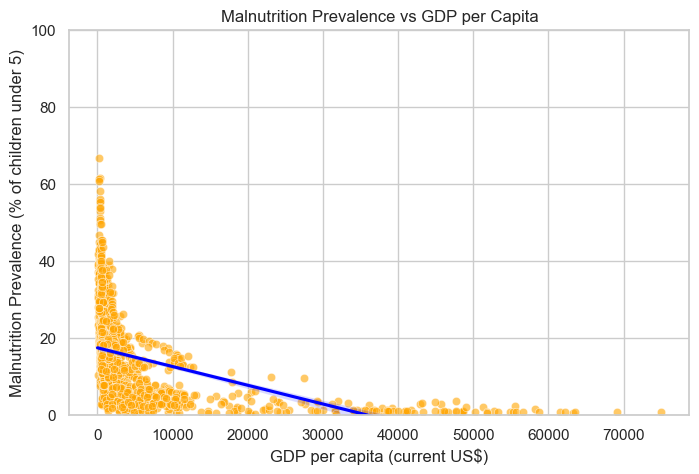

In [13]:


# Set the style of seaborn
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=malnutrition_gdp_merged_df, x=malnutrition_gdp_merged_df["GDP per capita (current US$)"], y=malnutrition_gdp_merged_df["Prevalence of underweight for age (% of children under 5)"], color="orange", alpha=0.6)
# Add a trend line using linear regression
sns.regplot(data=malnutrition_gdp_merged_df, 
            x="GDP per capita (current US$)", 
            y="Prevalence of underweight for age (% of children under 5)", 
            scatter=False,  # Do not plot the scatter points again
            color="blue", 
            line_kws={"label": "Trend Line", "color": "blue"})
plt.title('Malnutrition Prevalence vs GDP per Capita')
plt.xlabel('GDP per capita (current US$)')
plt.ylabel('Malnutrition Prevalence (% of children under 5)')
plt.grid(True)
# Set y-axis limits to avoid going below zero
plt.ylim(0, 100)  
plt.show()

#### Working with the other datasets that have the regional information and Income levels


In [15]:
# Load the new datasets with the correct delimiter
regional_info = pd.read_csv("GDP_INFORMATION.csv", delimiter=',', on_bad_lines='skip')
income_levels = pd.read_csv("Malnutrition_metadata.csv", delimiter=',', on_bad_lines='skip')

# Check the column names in the new datasets
print("Regional Info Columns:")
print(regional_info.columns)

print("\nIncome Levels Columns:")
print(income_levels.columns)

# Display the first few rows of the new datasets to understand their structure
print("\nRegional Info Data:")
print(regional_info.head())

print("\nIncome Levels Data:")
print(income_levels.head())

Regional Info Columns:
Index(['Country Code', 'Region', 'IncomeGroup', 'SpecialNotes', 'TableName',
       'Unnamed: 5'],
      dtype='object')

Income Levels Columns:
Index(['Country Code', 'Region', 'IncomeGroup', 'SpecialNotes', 'TableName',
       'Unnamed: 5'],
      dtype='object')

Regional Info Data:
  Country Code                     Region          IncomeGroup  \
0          ABW  Latin America & Caribbean          High income   
1          AFE                        NaN                  NaN   
2          AFG                 South Asia           Low income   
3          AFW                        NaN                  NaN   
4          AGO         Sub-Saharan Africa  Lower middle income   

                                        SpecialNotes  \
0                                                NaN   
1  26 countries, stretching from the Red Sea in t...   
2  The reporting period for national accounts dat...   
3  22 countries, stretching from the westernmost ...   
4  The World 

In [16]:
# Strip whitespace from column names in all DataFrames
malnutrition_gdp_merged_df.columns = malnutrition_gdp_merged_df.columns.str.strip()
regional_info.columns = regional_info.columns.str.strip()
income_levels.columns = income_levels.columns.str.strip()

In [17]:
# Merge malnutrition data with income levels
malnutrition_gdp_merged_data = pd.merge(
    malnutrition_gdp_merged_df,
    income_levels,
    on=["Country Code"],  # Adjust the key based on your actual column names
    how="left"  # Use left join to keep all rows from the previous merge
)

# Merge with regional information
final_malnutrition_gdp_merged_df = pd.merge(
    malnutrition_gdp_merged_data,
    regional_info,
    on=["Country Code"],  # Adjust the key based on your actual column names
    how="left"  # Use left join to keep all rows from merged_data
)

In [18]:
# Display the first few rows of the final merged DataFrame
print("\nFinal Merged Data:")
final_malnutrition_gdp_merged_df.head()


Final Merged Data:


Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                              Malnutrition Indicator  Year  \
0  Prevalence of underweight, weight for age (% o...  1960   
1  Prevalence of underweight, weight for age (% o...  1960   
2  Prevalence of underweight, weight for age (% o...  1960   
3  Prevalence of underweight, weight for age (% o...  1960   
4  Prevalence of underweight, weight for age (% o...  1960   

   Prevalence of underweight for age (% of children under 5)  \
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           

                  GDP Indicator  GDP per capita (current US$)  \
0  GDP per capita (current US$)                           NaN   
1  GDP per capita (current US$)                    162.342517   
2  GDP per capita (current US$)                           NaN   
3  GDP per capita (current US$)                    122.193931   
4  GDP per capita (current US$)                           NaN   

                    Region_x        IncomeGroup_x  \
0  Latin America & Caribbean          High income   
1                        NaN                  NaN   
2                 South Asia           Low income   
3                        NaN                  NaN   
4         Sub-Saharan Africa  Lower middle income   

                                      SpecialNotes_x  \
0                                                NaN   
1  26 countries, stretching from the Red Sea in t...   
2  The reporting period for national accounts dat...   
3  22 countries, stretching from the westernmost ...   
4  The World Bank systematically assesses the app...   

                   TableName_x  Unnamed: 5_x                   Region_y  \
0                        Aruba           NaN  Latin America & Caribbean   
1  Africa Eastern and Southern           NaN                        NaN   
2                  Afghanistan           NaN                 South Asia   
3   Africa Western and Central           NaN                        NaN   
4                       Angola           NaN         Sub-Saharan Africa   

         IncomeGroup_y                                     SpecialNotes_y  \
0          High income                                                NaN   
1                  NaN  26 countries, stretching from the Red Sea in t...   
2           Low income  The reporting period for national accounts dat...   
3                  NaN  22 countries, stretching from the westernmost ...   
4  Lower middle income  The World Bank systematically assesses the app...   

                   TableName_y  Unnamed: 5_y  
0                        Aruba           NaN  
1  Africa Eastern and Southern           NaN  
2                  Afghanistan           NaN  
3   Africa Western and Central           NaN  
4                       Angola           NaN

In [19]:
# Rename columns for clarity
final_malnutrition_gdp_merged_df.rename(columns={
    'Region_x': 'Region',
    'IncomeGroup_x': 'Income Group',
    'SpecialNotes_x': 'Special Notes',
    'TableName_x': 'Table Name',
    'Region_y': 'Region (Source)',
    'IncomeGroup_y': 'Income Group (Source)',
    'SpecialNotes_y': 'Special Notes (Source)',
    'TableName_y': 'Table Name (Source)',
}, inplace=True)

In [20]:
# Drop unnecessary columns and redundant columns
columns_to_drop = [
    'Unnamed: 5_x',  # Unnamed columns
    'Unnamed: 5_y',  # Unnamed columns
    'Special Notes',
    "Special Notes (Source)",
    "Income Group (Source)",
    "Table Name",
    "Region (Source)",
    "Table Name (Source)"
    
]

final_malnutrition_gdp_merged_df.drop(columns=columns_to_drop, inplace=True)

In [21]:
final_malnutrition_gdp_merged_df.head()

Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                              Malnutrition Indicator  Year  \
0  Prevalence of underweight, weight for age (% o...  1960   
1  Prevalence of underweight, weight for age (% o...  1960   
2  Prevalence of underweight, weight for age (% o...  1960   
3  Prevalence of underweight, weight for age (% o...  1960   
4  Prevalence of underweight, weight for age (% o...  1960   

   Prevalence of underweight for age (% of children under 5)  \
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           

                  GDP Indicator  GDP per capita (current US$)  \
0  GDP per capita (current US$)                           NaN   
1  GDP per capita (current US$)                    162.342517   
2  GDP per capita (current US$)                           NaN   
3  GDP per capita (current US$)                    122.193931   
4  GDP per capita (current US$)                           NaN   

                      Region         Income Group  
0  Latin America & Caribbean          High income  
1                        NaN                  NaN  
2                 South Asia           Low income  
3                        NaN                  NaN  
4         Sub-Saharan Africa  Lower middle income

In [22]:
# Drop rows where 'Region' is 'North America'
final_malnutrition_gdp_merged_df = final_malnutrition_gdp_merged_df[final_malnutrition_gdp_merged_df['Region'] != 'North America']

In [23]:
final_malnutrition_gdp_merged_df["Prevalence of underweight for age (% of children under 5)"].min()

0.0

In [24]:
# Check if there are any rows with 'Region' equal to 'North America'
print("North America in 'Region' column:", (final_malnutrition_gdp_merged_df['Region'] == 'North America').any())


North America in 'Region' column: False


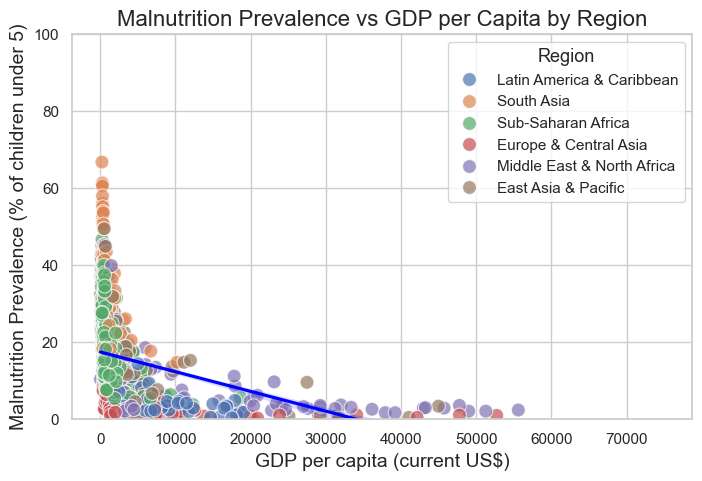

In [25]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(8, 5))

# Use hue to differentiate by region
scatter = sns.scatterplot(data=final_malnutrition_gdp_merged_df, 
                           x="GDP per capita (current US$)", 
                           y="Prevalence of underweight for age (% of children under 5)", 
                           hue="Region",  # Different colors for each region
                           palette="deep",  # Color palette
                           s=100,  # Size of the points
                           alpha=0.7)  # Transparency of the points

sns.regplot(data=final_malnutrition_gdp_merged_df, 
            x="GDP per capita (current US$)", 
            y="Prevalence of underweight for age (% of children under 5)", 
            scatter=False,  # Do not plot the scatter points again
            color="blue", 
            line_kws={"label": "Trend Line", "color": "blue"})
# Add title and labels
plt.title('Malnutrition Prevalence vs GDP per Capita by Region', fontsize=16)
plt.xlabel('GDP per capita (current US$)', fontsize=14)
plt.ylabel('Malnutrition Prevalence (% of children under 5)', fontsize=14)
  
plt.grid(True)

# Show legend
plt.legend(title='Region', title_fontsize='13', fontsize='11')
plt.ylim(0, 100)
# Show the plot
plt.show()

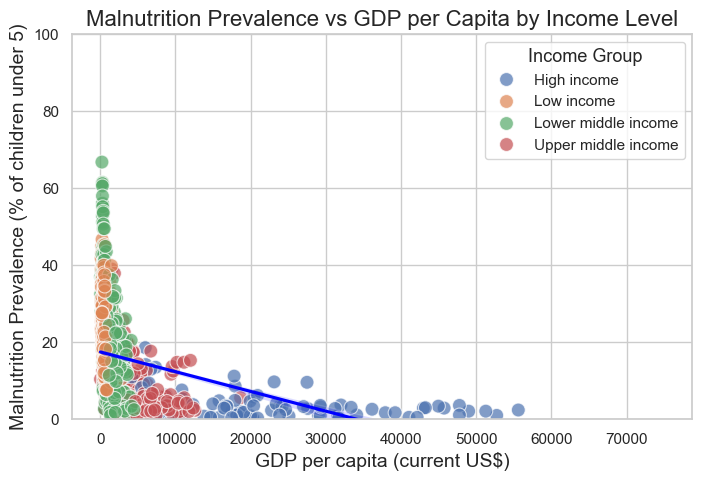

In [26]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(8, 5))

# Use hue to differentiate by region
scatter = sns.scatterplot(data=final_malnutrition_gdp_merged_df, 
                           x="GDP per capita (current US$)", 
                           y="Prevalence of underweight for age (% of children under 5)", 
                           hue="Income Group",  # Different colors for each region
                           palette="deep",  # Color palette
                           s=100,  # Size of the points
                           alpha=0.7)  # Transparency of the points

sns.regplot(data=final_malnutrition_gdp_merged_df, 
            x="GDP per capita (current US$)", 
            y="Prevalence of underweight for age (% of children under 5)", 
            scatter=False,  # Do not plot the scatter points again
            color="blue", 
            line_kws={"label": "Trend Line", "color": "blue"})
# Add title and labels
plt.title('Malnutrition Prevalence vs GDP per Capita by Income Level', fontsize=16)
plt.xlabel('GDP per capita (current US$)', fontsize=14)
plt.ylabel('Malnutrition Prevalence (% of children under 5)', fontsize=14)

# Set x-axis to log scale for better visualization
# plt.xscale('log')  
plt.grid(True)

# Show legend
plt.legend(title='Income Group', title_fontsize='13', fontsize='11')
plt.ylim(0, 100)
# Show the plot
plt.show()

## Question 2: Synchronizing the 3 data sets and ploting the time series 

In [28]:
#!pip install quandl

In [29]:
# import quandl
# quandl.ApiConfig.api_key = "21Mf49bKdKXKhJK4cvQd"


In [30]:
# from IPython.display import display, HTML
# display(HTML('<b>Loading the data using the quandL codes provided</b></div>'))


In [31]:

# wheat_prices_data = quandl.get("COM/PWHEAMT_USD", start_date = "1990-01-01")

In [32]:
# gold_prices_data = quandl.get("BUNDESBANK/BBK01_WT5511", start_date = "1990-01-01")

In [33]:
# crude_oil_prices_data = quandl.get("WGEC/WLD_CRUDE_WTI", start_date = "1990-01-01")

In [34]:

wheat_prices_data = pd.read_csv("wheat.csv")

In [35]:
gold_prices_data = pd.read_csv("gold.csv")

In [36]:
crude_oil_prices_data = pd.read_csv("crude-oil.csv")

In [37]:
wheat_prices_data.head()

Date       Value
0  1980-01-31  175.634750
1  1980-02-29  172.695236
2  1980-03-31  163.509323
3  1980-04-30  156.528030
4  1980-05-31  161.304703

In [38]:
crude_oil_prices_data.head()

Date  Value
0  1960-12-31    0.0
1  1961-12-31    0.0
2  1962-12-31    0.0
3  1963-12-31    0.0
4  1964-12-31    0.0

In [39]:
gold_prices_data.head()

Date  Value
0  1968-04-01   38.0
1  1968-04-02   37.6
2  1968-04-03   37.7
3  1968-04-04   36.7
4  1968-04-05   37.2

In [40]:
def synchronize_timestamps(datasets):
    """
    Synchronizes timestamps across multiple datasets, ensuring all datasets start from 1980.
    
    Args:
        datasets (dict): A dictionary where keys are dataset names and values are DataFrames containing the data.
        
    Returns:
        pd.DataFrame: A synchronized DataFrame with all datasets aligned by timestamp.
    """
    # Create a new time index starting from 1980-01-01
    start_date = pd.Timestamp('1980-01-01')
    all_timestamps = pd.DatetimeIndex([])

    for name, dataset in datasets.items():
        # Ensure the index is a DatetimeIndex
        if not isinstance(dataset.index, pd.DatetimeIndex):
            raise ValueError(f"The dataset '{name}' does not have a DatetimeIndex.")
        
        # Filter the dataset to include only dates from 1980 onwards
        filtered_dates = dataset.index[dataset.index >= start_date]
        all_timestamps = all_timestamps.union(filtered_dates)  # Collect all unique timestamps
    
    # Reindex each dataset to the new time index and interpolate missing values
    synchronized_datasets = {}
    for name, dataset in datasets.items():
        # Filter the dataset to include only dates from 1980 onwards
        filtered_dataset = dataset[dataset.index >= start_date]
        
        synchronized_dataset = filtered_dataset.reindex(all_timestamps)  # Synchronization: Align to common timestamps
        synchronized_dataset = synchronized_dataset.interpolate(method='time')  # Fill missing values
        synchronized_datasets[name] = synchronized_dataset
    
    # Combine all synchronized datasets into a single DataFrame
    synchronized_data = pd.concat(synchronized_datasets.values(), axis=1)  # Combine aligned datasets
    synchronized_data.columns = synchronized_datasets.keys()  # Set column names
    
    return synchronized_data  # Return the synchronized DataFrame

In [41]:
wheat_prices_data['Date'] = pd.to_datetime(wheat_prices_data['Date'])  # Convert to datetime
wheat_prices_data.set_index('Date', inplace=True)  

In [42]:
crude_oil_prices_data['Date'] = pd.to_datetime(crude_oil_prices_data['Date'])  # Convert to datetime
crude_oil_prices_data.set_index('Date', inplace=True)  

In [43]:
gold_prices_data['Date'] = pd.to_datetime(gold_prices_data['Date'])  # Convert to datetime
gold_prices_data.set_index('Date', inplace=True)  

In [44]:
datasets = {
    'Wheat': wheat_prices_data[['Value']],
    'Crude Oil': crude_oil_prices_data[['Value']],
    'Gold': gold_prices_data[['Value']]
}



In [45]:
synchronized_data = synchronize_timestamps(datasets)

In [46]:
synchronized_data.head()

Wheat  Crude Oil    Gold
1980-01-02    NaN        NaN  559.00
1980-01-03    NaN        NaN  632.00
1980-01-04    NaN        NaN  596.00
1980-01-07    NaN        NaN  634.00
1980-01-08    NaN        NaN  615.75

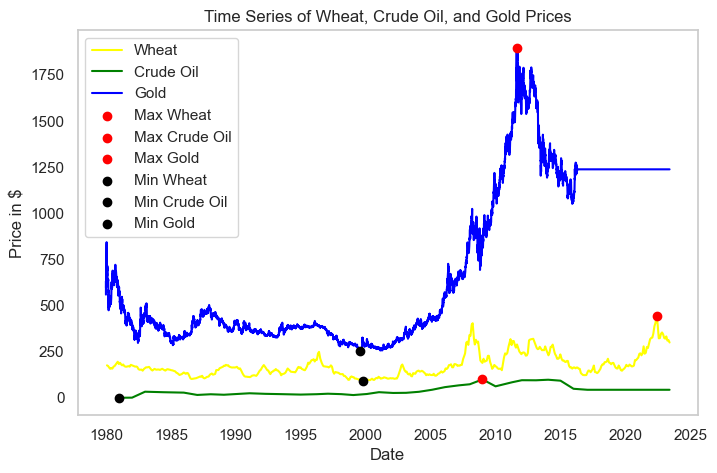

In [47]:


# Plotting the synchronized data
plt.figure(figsize=(8, 5))
plt.plot(synchronized_data.index, synchronized_data['Wheat'], label='Wheat', color='yellow')
plt.plot(synchronized_data.index, synchronized_data['Crude Oil'], label='Crude Oil', color='green')
plt.plot(synchronized_data.index, synchronized_data['Gold'], label='Gold', color='blue')

# Highlight max prices
for column in synchronized_data.columns:
    max_index = synchronized_data[column].idxmax()  # Get index of max value
    plt.scatter(max_index, synchronized_data[column].max(), color='red', label=f'Max {column}', zorder=5)

# Highlight min prices
for column in synchronized_data.columns:
    min_index = synchronized_data[column].idxmin()  # Get index of min value
    plt.scatter(min_index, synchronized_data[column].min(), color='black', label=f'Min {column}', zorder=5)

# Adding titles and labels
plt.title('Time Series of Wheat, Crude Oil, and Gold Prices')
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.legend()
plt.grid()
plt.show()

### Question 3: Summary statistic from the CO2 emissions (metric tons per capita) data and primary school data

#### Summary statistic from the CO2 emissions (metric tons per capita)

##### using the clean_and_reshape_data function defined in question 1

In [51]:
CO2_emissions_data  = clean_and_reshape_data('CO2.csv', id_vars=['Country Name', 'Country Code', 'Indicator Name'])

Data loaded successfully:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                           Indicator Name  Indicator Code  1960  1961  1962  \
0  CO2 emissions (metric tons per capita)  EN.ATM.CO2E.PC   NaN   NaN   NaN   
1  CO2 emissions (metric tons per capita)  EN.ATM.CO2E.PC   NaN   NaN   NaN   
2  CO2 emissions (metric tons per capita)  EN.ATM.CO2E.PC   NaN   NaN   NaN   
3  CO2 emissions (metric tons per capita)  EN.ATM.CO2E.PC   NaN   NaN   NaN   
4  CO2 emissions (metric tons per capita)  EN.ATM.CO2E.PC   NaN   NaN   NaN   

   1963  1964  1965  ...      2015      2016      2017      2018      2019  \
0   NaN   NaN   NaN  ...       NaN       NaN       NaN       NaN       NaN   
1   NaN   NaN   NaN  ...  0.960430  0.941337  0.933874  0.92

In [52]:
CO2_emissions_data.head()

Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                           Indicator Name  Year  Value  
0  CO2 emissions (metric tons per capita)  1960    NaN  
1  CO2 emissions (metric tons per capita)  1960    NaN  
2  CO2 emissions (metric tons per capita)  1960    NaN  
3  CO2 emissions (metric tons per capita)  1960    NaN  
4  CO2 emissions (metric tons per capita)  1960    NaN

In [53]:
#Get the different column names
print(CO2_emissions_data.columns)

Index(['Country Name', 'Country Code', 'Indicator Name', 'Year', 'Value'], dtype='object')


In [54]:
# Filter for the year 2010
CO2_emissions_data_2010 = CO2_emissions_data[CO2_emissions_data["Year"] == "2010"]

In [55]:
# Make sure the renaming is applied to the DataFrame
CO2_emissions_data_2010.rename(columns={"Value": "CO2 emissions (metric tons per capita)"}, inplace=True)


C:\Users\STUDENT\AppData\Local\Temp\ipykernel_3112\4181817188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CO2_emissions_data_2010.rename(columns={"Value": "CO2 emissions (metric tons per capita)"}, inplace=True)


In [56]:
#Check the number of missing data
CO2_emissions_data_2010.isna().sum()

Country Name                               0
Country Code                               0
Indicator Name                             0
Year                                       0
CO2 emissions (metric tons per capita)    27
dtype: int64

In [57]:
CO2_emissions_data_2010.count()

Country Name                              266
Country Code                              266
Indicator Name                            266
Year                                      266
CO2 emissions (metric tons per capita)    239
dtype: int64

In [58]:
#Since the percentage of missing data is relatively low (27 out 239), 
#using the mean or median of the non-missing values to impute the missing values in the 'CO2 Emissions' column can be a simple and effective approach


In [59]:
#This shows

#CO2_emissions_data_2010 = data[['Country Name', '2010']].fillna(0)
mean_co2 = CO2_emissions_data_2010['CO2 emissions (metric tons per capita)'].mean()
CO2_emissions_data_2010['CO2 emissions (metric tons per capita)'] = CO2_emissions_data_2010['CO2 emissions (metric tons per capita)'].fillna(mean_co2)

C:\Users\STUDENT\AppData\Local\Temp\ipykernel_3112\396533509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CO2_emissions_data_2010['CO2 emissions (metric tons per capita)'] = CO2_emissions_data_2010['CO2 emissions (metric tons per capita)'].fillna(mean_co2)


In [60]:

# Calculate summary statistics
mean = CO2_emissions_data_2010['CO2 emissions (metric tons per capita)'].mean()
median = CO2_emissions_data_2010["CO2 emissions (metric tons per capita)"].median()
std_dev = CO2_emissions_data_2010["CO2 emissions (metric tons per capita)"].std()
percentiles = np.percentile(CO2_emissions_data_2010['CO2 emissions (metric tons per capita)'], [5, 25, 75, 95])

# Prepare the summary statistics in a list format
summary_statistics = [
    ['Average CO2 Emissions', mean],
    ['Median CO2 Emissions', median],
    ['Standard Deviation of CO2 Emissions', std_dev],
    ['5th Percentile of CO2 Emissions', percentiles[0]],
    ['25th Percentile of CO2 Emissions', percentiles[1]],
    ['75th Percentile of CO2 Emissions', percentiles[2]],
    ['95th Percentile of CO2 Emissions', percentiles[3]]
]

# Display the summary statistics table
print(tabulate(summary_statistics, headers=['Statistic', 'Value'], tablefmt='pretty'))

+-------------------------------------+--------------------+
|              Statistic              |       Value        |
+-------------------------------------+--------------------+
|        Average CO2 Emissions        | 4.4075968165399555 |
|        Median CO2 Emissions         |  3.38926080746352  |
| Standard Deviation of CO2 Emissions | 4.894856924399748  |
|   5th Percentile of CO2 Emissions   | 0.1312550077436915 |
|  25th Percentile of CO2 Emissions   | 0.8487846885347875 |
|  75th Percentile of CO2 Emissions   | 5.667502661544362  |
|  95th Percentile of CO2 Emissions   | 14.028622986382398 |
+-------------------------------------+--------------------+


#### Summary statistic for the Primary school data

In [62]:
primary_school_enrolment_data  = clean_and_reshape_data('primaryschooldata.csv', id_vars=['Country Name', 'Country Code', 'Indicator Name'])

Data loaded successfully:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                       Indicator Name Indicator Code  1960  1961  1962  1963  \
0  School enrollment, primary (% net)    SE.PRM.NENR   NaN   NaN   NaN   NaN   
1  School enrollment, primary (% net)    SE.PRM.NENR   NaN   NaN   NaN   NaN   
2  School enrollment, primary (% net)    SE.PRM.NENR   NaN   NaN   NaN   NaN   
3  School enrollment, primary (% net)    SE.PRM.NENR   NaN   NaN   NaN   NaN   
4  School enrollment, primary (% net)    SE.PRM.NENR   NaN   NaN   NaN   NaN   

   1964  1965  ...  2015  2016  2017  2018  2019  2020  2021  2022  2023  \
0   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   N

In [63]:
primary_school_enrolment_data.head()

Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                       Indicator Name  Year  Value  
0  School enrollment, primary (% net)  1960    NaN  
1  School enrollment, primary (% net)  1960    NaN  
2  School enrollment, primary (% net)  1960    NaN  
3  School enrollment, primary (% net)  1960    NaN  
4  School enrollment, primary (% net)  1960    NaN

In [64]:
primary_school_enrolment_data.isna().sum()

Country Name          0
Country Code          0
Indicator Name        0
Year                  0
Value             10821
dtype: int64

In [65]:
primary_school_enrolment_data_2010 = primary_school_enrolment_data[primary_school_enrolment_data["Year"] == "2010"]

primary_school_enrolment_data_2010.head()

Country Name Country Code  \
13300                        Aruba          ABW   
13301  Africa Eastern and Southern          AFE   
13302                  Afghanistan          AFG   
13303   Africa Western and Central          AFW   
13304                       Angola          AGO   

                           Indicator Name  Year     Value  
13300  School enrollment, primary (% net)  2010  98.91975  
13301  School enrollment, primary (% net)  2010       NaN  
13302  School enrollment, primary (% net)  2010       NaN  
13303  School enrollment, primary (% net)  2010       NaN  
13304  School enrollment, primary (% net)  2010  75.80242

In [66]:
primary_school_enrolment_data_2010.isna().sum()

Country Name        0
Country Code        0
Indicator Name      0
Year                0
Value             100
dtype: int64

In [67]:
primary_school_enrolment_data_2010.count()

Country Name      266
Country Code      266
Indicator Name    266
Year              266
Value             166
dtype: int64

In [68]:
# Make sure the renaming is applied to the DataFrame
primary_school_enrolment_data_2010.rename(columns={"Value": "School enrolment, primary (% net)"}, inplace=True)

C:\Users\STUDENT\AppData\Local\Temp\ipykernel_3112\640726121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_school_enrolment_data_2010.rename(columns={"Value": "School enrolment, primary (% net)"}, inplace=True)


In [69]:
#This shows

#CO2_emissions_data_2010 = data[['Country Name', '2010']].fillna(0)
mean_co2 = primary_school_enrolment_data_2010['School enrolment, primary (% net)'].mean()
primary_school_enrolment_data_2010['School enrolment, primary (% net)'] = primary_school_enrolment_data_2010['School enrolment, primary (% net)'].fillna(mean_co2)

C:\Users\STUDENT\AppData\Local\Temp\ipykernel_3112\849159953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_school_enrolment_data_2010['School enrolment, primary (% net)'] = primary_school_enrolment_data_2010['School enrolment, primary (% net)'].fillna(mean_co2)


In [70]:
primary_school_enrolment_data_2010.isna().sum()

Country Name                         0
Country Code                         0
Indicator Name                       0
Year                                 0
School enrolment, primary (% net)    0
dtype: int64

In [71]:

# Calculate summary statistics
mean = primary_school_enrolment_data_2010['School enrolment, primary (% net)'].mean()
median = primary_school_enrolment_data_2010['School enrolment, primary (% net)'].median()
std_dev = primary_school_enrolment_data_2010['School enrolment, primary (% net)'].std()
percentiles = np.percentile(primary_school_enrolment_data_2010['School enrolment, primary (% net)'], [5, 25, 75, 95])

# Prepare the summary statistics in a list format
summary_statistics = [
    ['Average Primary School Enrolment', mean],
    ['Median Primary School Enrolment', median],
    ['Standard Deviation of Primary School Enrolment', std_dev],
    ['5th Percentile of Primary School Enrolment', percentiles[0]],
    ['25th Percentile of Primary School Enrolment', percentiles[1]],
    ['75th Percentile of Primary School Enrolment', percentiles[2]],
    ['95th Percentile of Primary School Enrolment', percentiles[3]]
]

# Display the summary statistics table
print(tabulate(summary_statistics, headers=['Statistic', 'Value'], tablefmt='pretty'))

+------------------------------------------------+--------------------+
|                   Statistic                    |       Value        |
+------------------------------------------------+--------------------+
|        Average Primary School Enrolment        | 90.10508843373493  |
|        Median Primary School Enrolment         | 90.10508843373495  |
| Standard Deviation of Primary School Enrolment | 7.5180255076075975 |
|   5th Percentile of Primary School Enrolment   |      72.61845      |
|  25th Percentile of Primary School Enrolment   | 90.10508843373495  |
|  75th Percentile of Primary School Enrolment   |     94.6956175     |
|  95th Percentile of Primary School Enrolment   |     98.1973825     |
+------------------------------------------------+--------------------+


## Question 4: CDF for Fertility rate and compare the relationship between fertility rate and GPD per capita

In [73]:
# Using the function we created at beginning for cleaning data
female_fertility_rate = clean_and_reshape_data('FertilityforWomen.csv', id_vars=['Country Name', 'Country Code', 'Indicator Name'])

Data loaded successfully:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                             Indicator Name  Indicator Code      1960  \
0  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  4.820000   
1  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  6.724125   
2  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  7.282000   
3  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  6.458448   
4  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  6.708000   

       1961      1962      1963      1964      1965  ...      2015      2016  \
0  4.655000  4.471000  4.271000  4.059000  3.842000  ...  1.972000  1.953000   
1  6.742752  6.762930  6.778712  6.788420  6.800322  ...  4.677618  4.615670   
2  7.284000 

In [74]:
#getting the data for 2010 for the fertility rate
female_fertility_rate_2010 = female_fertility_rate[female_fertility_rate["Year"]=="2010"]
female_fertility_rate_2010.head()

Country Name Country Code  \
13300                        Aruba          ABW   
13301  Africa Eastern and Southern          AFE   
13302                  Afghanistan          AFG   
13303   Africa Western and Central          AFW   
13304                       Angola          AGO   

                                 Indicator Name  Year     Value  
13300  Fertility rate, total (births per woman)  2010  1.941000  
13301  Fertility rate, total (births per woman)  2010  5.040797  
13302  Fertility rate, total (births per woman)  2010  6.099000  
13303  Fertility rate, total (births per woman)  2010  5.699552  
13304  Fertility rate, total (births per woman)  2010  6.194000

In [75]:
#getting the data for 2010 for the gdp_per_capita_data data frame we obtained in question one
gdp_per_capita_data_2010 = gdp_per_capita_data[gdp_per_capita_data["Year"] == "2010"]
gdp_per_capita_data_2010.head()


Country Name Country Code                Indicator Name  \
13300                        Aruba          ABW  GDP per capita (current US$)   
13301  Africa Eastern and Southern          AFE  GDP per capita (current US$)   
13302                  Afghanistan          AFG  GDP per capita (current US$)   
13303   Africa Western and Central          AFW  GDP per capita (current US$)   
13304                       Angola          AGO  GDP per capita (current US$)   

       Year         Value  
13300  2010  24452.588739  
13301  2010   1622.684093  
13302  2010    562.499222  
13303  2010   1680.141063  
13304  2010   3586.663694

In [76]:
# Merge the melted datasets on Country Code and Year
fertility_gdp_data = pd.merge(
    female_fertility_rate_2010,
    gdp_per_capita_data_2010,
    on=["Country Code", "Year"],  # Merge on Country Code and Year
    how="inner"  # Inner join to keep only matching rows
)

# Renaming columns for clarity
fertility_gdp_data.rename(columns={
    'Value_x': 'Fertility rate total (births per woman)',  # Rename the malnutrition value column
    'Value_y': 'GDP per Capita (current US$)',  # Rename the GDP value column
    'Indicator Name_x': 'Fertility rate Indicator',  # Rename the malnutrition indicator column
    'Indicator Name_y': 'GDP Indicator'  # Rename the GDP indicator column
}, inplace=True)

# Display the merged DataFrame
fertility_gdp_data.head()

Country Name_x Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                   Fertility rate Indicator  Year  \
0  Fertility rate, total (births per woman)  2010   
1  Fertility rate, total (births per woman)  2010   
2  Fertility rate, total (births per woman)  2010   
3  Fertility rate, total (births per woman)  2010   
4  Fertility rate, total (births per woman)  2010   

   Fertility rate total (births per woman)               Country Name_y  \
0                                 1.941000                        Aruba   
1                                 5.040797  Africa Eastern and Southern   
2                                 6.099000                  Afghanistan   
3                                 5.699552   Africa Western and Central   
4                                 6.194000                       Angola   

                  GDP Indicator  GDP per Capita (current US$)  
0  GDP per capita (current US$)                  24452.588739  
1  GDP per capita (current US$)                   1622.684093  
2  GDP per capita (current US$)                    562.499222  
3  GDP per capita (current US$)                   1680.141063  
4  GDP per capita (current US$)                   3586.663694

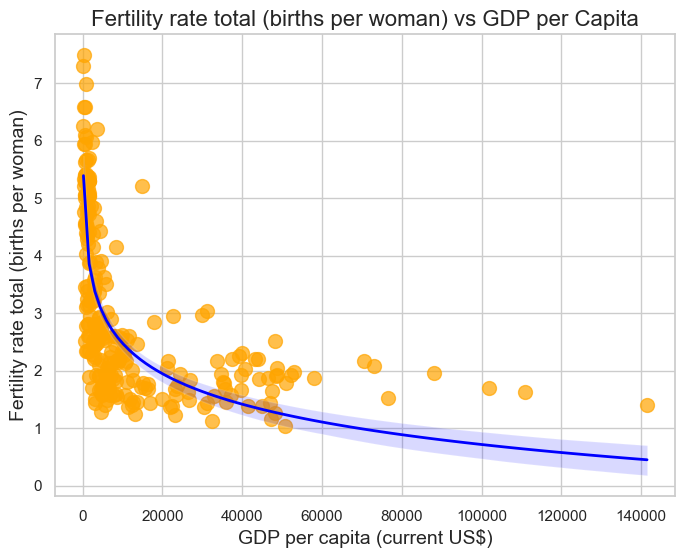

In [77]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a scatter plot with a trend line
plt.figure(figsize=(8, 6))

# Use regplot to create the scatter plot with a trend line
scatter = sns.regplot(data=fertility_gdp_data, 
                      x="GDP per Capita (current US$)", 
                      y="Fertility rate total (births per woman)", 
                      scatter_kws={'s': 100, 'color': 'orange', 'alpha': 0.7},  # Size and color of the points
                      line_kws={'color': 'blue', 'linewidth': 2},  # Color and width of the trend line
                      logx=True)  # Set x-axis to log scale

# Add title and labels
plt.title('Fertility rate total (births per woman) vs GDP per Capita', fontsize=16)
plt.xlabel('GDP per capita (current US$)', fontsize=14)
plt.ylabel('Fertility rate total (births per woman)', fontsize=14)

# Show the plot
plt.grid(True)
plt.show()

#### Cumulative distribution Function

In [79]:
# getting the data for 1990
female_fertility_rate_1990 = female_fertility_rate[female_fertility_rate["Year"] == "1990"]

In [80]:
female_fertility_rate_1990.head()

Country Name Country Code  \
7980                        Aruba          ABW   
7981  Africa Eastern and Southern          AFE   
7982                  Afghanistan          AFG   
7983   Africa Western and Central          AFW   
7984                       Angola          AGO   

                                Indicator Name  Year     Value  
7980  Fertility rate, total (births per woman)  1990  2.303000  
7981  Fertility rate, total (births per woman)  1990  6.166608  
7982  Fertility rate, total (births per woman)  1990  7.565000  
7983  Fertility rate, total (births per woman)  1990  6.518278  
7984  Fertility rate, total (births per woman)  1990  7.272000

In [81]:

# Extract fertility rates
female_fertility_1990_values = female_fertility_rate_1990['Value']
female_fertility_2010_values = female_fertility_rate_2010['Value']

# Create DataFrames for CDF calculation 
female_fertility_rate_1990 = pd.DataFrame({'Female Fertility Rate': female_fertility_1990_values})
female_fertility_rate_2010 = pd.DataFrame({'Female Fertility Rate': female_fertility_2010_values})



In [82]:
female_fertility_rate_1990.head()

Female Fertility Rate
7980               2.303000
7981               6.166608
7982               7.565000
7983               6.518278
7984               7.272000

In [83]:
# Calculate CDF
female_fertility_rate_1990['CDF'] = female_fertility_rate_1990['Female Fertility Rate'].rank() / len(female_fertility_rate_1990)
female_fertility_rate_2010['CDF'] = female_fertility_rate_2010['Female Fertility Rate'].rank() / len(female_fertility_rate_2010)



In [84]:
# Sort values for plotting
female_fertility_rate_1990 = female_fertility_rate_1990.sort_values('Female Fertility Rate')
female_fertility_rate_2010 = female_fertility_rate_2010.sort_values('Female Fertility Rate')

# Calculate mean and median
average_female_fertility_rate_1990 = female_fertility_rate_1990['Female Fertility Rate'].mean()
median_female_fertility_rate_1990 = female_fertility_rate_1990['Female Fertility Rate'].median()
average_female_fertility_rate_2010 = female_fertility_rate_2010['Female Fertility Rate'].mean()
median_female_fertility_rate_2010 = female_fertility_rate_2010['Female Fertility Rate'].median()



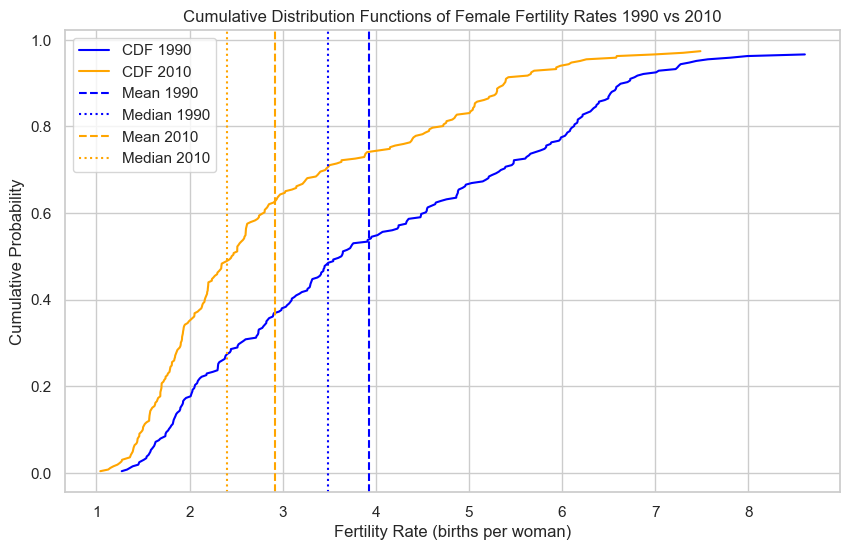

In [85]:
# Plotting CDFs
plt.figure(figsize=(10, 6))
plt.plot(female_fertility_rate_1990['Female Fertility Rate'], female_fertility_rate_1990['CDF'], label='CDF 1990', color='blue')
plt.plot(female_fertility_rate_2010['Female Fertility Rate'], female_fertility_rate_2010['CDF'], label='CDF 2010', color='orange')

# Add vertical lines for mean and median
plt.axvline(average_female_fertility_rate_1990, color='blue', linestyle='--', label='Mean 1990')
plt.axvline(median_female_fertility_rate_1990, color='blue', linestyle=':', label='Median 1990')
plt.axvline(average_female_fertility_rate_2010, color='orange', linestyle='--', label='Mean 2010')
plt.axvline(median_female_fertility_rate_2010, color='orange', linestyle=':', label='Median 2010')

# Adding titles and labels
plt.title('Cumulative Distribution Functions of Female Fertility Rates 1990 vs 2010')
plt.xlabel('Fertility Rate (births per woman)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

### Question 5: Understanding the relationship between Happy Planet index and Corruption Perception Index


In [87]:

happy_planet_index = pd.read_excel("hpi-data-2016.xlsx", sheet_name="Complete HPI data", skiprows=5)
corruption_perception_index = pd.read_excel("CPI2016_Results.xlsx")

C:\Users\STUDENT\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


In [88]:
corruption_perception_index.head()

Country  CPI2016  Rank Region WB Code  World Bank CPIA  \
0  New Zealand       90     1     AP     NZL              NaN   
1      Denmark       90     1  WE/EU     DNK              NaN   
2      Finland       89     3  WE/EU     FIN              NaN   
3       Sweden       88     4  WE/EU     SWE              NaN   
4  Switzerland       86     5  WE/EU     CHE              NaN   

   World Economic Forum EOS  Global Insight Country Risk Ratings  \
0                      90.0                                   83   
1                      85.0                                   83   
2                      91.0                                   83   
3                      86.0                                   83   
4                      80.0                                   83   

   Bertelsmann Foundation Transformation Index  African Development Bank CPIA  \
0                                          NaN                            NaN   
1                                          NaN                            NaN   
2                                          NaN                            NaN   
3                                          NaN                            NaN   
4                                          NaN                            NaN   

   ...  Std Error 2016  Lower CI  Upper CI  Min  Max  OECD  G20  BRICS   EU  \
0  ...            2.56        86        94   79   99     y  NaN    NaN  NaN   
1  ...            2.46        86        94   83   99     y  NaN    NaN    y   
2  ...            1.46        87        92   83   94     y  NaN    NaN    y   
3  ...            1.33        85        90   83   93     y  NaN    NaN    y   
4  ...            1.57        83        89   80   90     y  NaN    NaN  NaN   

   Arab states  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 32 columns]

In [89]:
# Rename the "Rank" column to "CPI Rank"
corruption_perception_index = corruption_perception_index.rename(columns={'Rank': 'CPI Rank'})

In [90]:
happy_planet_index.head()

Unnamed: 0  HPI Rank      Country                        Region  \
0         NaN     110.0  Afghanistan  Middle East and North Africa   
1         NaN      13.0      Albania                Post-communist   
2         NaN      30.0      Algeria  Middle East and North Africa   
3         NaN      19.0    Argentina                      Americas   
4         NaN      73.0      Armenia                Post-communist   

   Average Life \nExpectancy  Average Wellbeing\n(0-10)  Happy Life Years  \
0                     59.668                        3.8         12.396024   
1                     77.347                        5.5         34.414736   
2                     74.313                        5.6         30.469461   
3                     75.927                        6.5         40.166674   
4                     74.446                        4.3         24.018760   

   Footprint\n(gha/capita)  Inequality of Outcomes  \
0                     0.79                0.426557   
1                     2.21                0.165134   
2                     2.12                0.244862   
3                     3.14                0.164238   
4                     2.23                0.216648   

   Inequality-adjusted Life Expectancy  Inequality-adjusted Wellbeing  \
0                            38.348818                       3.390494   
1                            69.671159                       5.097650   
2                            60.474545                       5.196449   
3                            68.349583                       6.034707   
4                            66.921682                       3.747140   

   Happy Planet Index  GDP/capita\n($PPP)  Population        GINI index  
0           20.225350          690.842629  29726803.0  Data unavailable  
1           36.766874         4247.485437   2900489.0             28.96  
2           33.300543         5583.616160  37439427.0  Data unavailable  
3           35.190244        14357.411589  42095224.0             42.49  
4           25.666417         3565.517575   2978339.0             30.48

In [91]:
# Merge datasets on country names to get common countries between them
hpi_cpi_merged_df = pd.merge(happy_planet_index, corruption_perception_index, on='Country')



In [92]:
hpi_cpi_merged_df.head()

Unnamed: 0  HPI Rank      Country                      Region_x  \
0         NaN     110.0  Afghanistan  Middle East and North Africa   
1         NaN      13.0      Albania                Post-communist   
2         NaN      30.0      Algeria  Middle East and North Africa   
3         NaN      19.0    Argentina                      Americas   
4         NaN      73.0      Armenia                Post-communist   

   Average Life \nExpectancy  Average Wellbeing\n(0-10)  Happy Life Years  \
0                     59.668                        3.8         12.396024   
1                     77.347                        5.5         34.414736   
2                     74.313                        5.6         30.469461   
3                     75.927                        6.5         40.166674   
4                     74.446                        4.3         24.018760   

   Footprint\n(gha/capita)  Inequality of Outcomes  \
0                     0.79                0.426557   
1                     2.21                0.165134   
2                     2.12                0.244862   
3                     3.14                0.164238   
4                     2.23                0.216648   

   Inequality-adjusted Life Expectancy  ...  Std Error 2016  Lower CI  \
0                            38.348818  ...            1.74        12   
1                            69.671159  ...            1.99        36   
2                            60.474545  ...            2.94        29   
3                            68.349583  ...            1.76        33   
4                            66.921682  ...            4.01        26   

   Upper CI  Min Max  OECD  G20 BRICS   EU  Arab states  
0        17   10  20   NaN  NaN   NaN  NaN          NaN  
1        42   30  47   NaN  NaN   NaN  NaN          NaN  
2        39   22  44   NaN  NaN   NaN  NaN            y  
3        39   29  46   NaN    y   NaN  NaN          NaN  
4        40   17  45   NaN  NaN   NaN  NaN          NaN  

[5 rows x 46 columns]

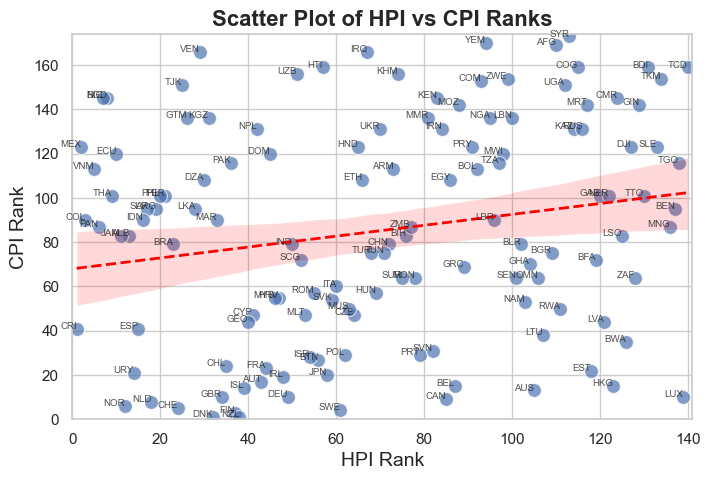

In [93]:
# Check for missing values and drop them
hpi_cpi_merged_df.dropna(subset=['HPI Rank', 'CPI Rank'], inplace=True)

# Create a scatter plot using Seaborn for better aesthetics
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")  # Set the background style

# Scatter plot of HPI Rank vs. CPI Rank
scatter_plot = sns.scatterplot(data=hpi_cpi_merged_df, x='HPI Rank', y='CPI Rank', 
                
                                s=100,  # Size of points
                                edgecolor='w',  # White edge color for better visibility
                                alpha=0.7)  # Transparency of points

# Adding a regression line to show the trend
sns.regplot(data=hpi_cpi_merged_df, x='HPI Rank', y='CPI Rank', 
            scatter=False,  # Don't plot scatter points again
            color='red',  # Color of the regression line
            line_kws={'linewidth': 2, 'linestyle': '--'})  # Customize line style

# Annotate points with ISO country codes
for i, row in hpi_cpi_merged_df.iterrows():
    plt.annotate(row['WB Code'], 
                 (row['HPI Rank'], row['CPI Rank']),
                 fontsize=7, 
                 alpha=0.8, 
                 horizontalalignment='right')

# Customizing the plot
plt.title('Scatter Plot of HPI vs CPI Ranks', fontsize=16, fontweight='bold')
plt.xlabel('HPI Rank', fontsize=14)
plt.ylabel('CPI Rank', fontsize=14)
plt.xlim(0, max(hpi_cpi_merged_df['HPI Rank']) + 1)  # Set x-axis limits
plt.ylim(0, max(hpi_cpi_merged_df['CPI Rank']) + 1)  # Set y-axis limits
plt.grid(True)  # Show grid

# Show the plot
plt.show()